# 1. Random Walks on Graphs

a) Create a power law cluster graph with a number of nodes between n = 50
and n = 100. Save the graph. Make sure that for the following you always
use the same graph. Why is this important?

b) What values for m and p yield a graph containing a number of clusters
below 10 which are sufficiently clearly distinguishable? Visualize the graph
in a way the clusters and node labels are clearly recognizeable.

c) Select two nodes in the graph as starting point for two random walkers.
Let the walkers walk across the graph (at each step they choose randomly
between the neighbors of their current node) until they meet.

d) How does the time until the walkers meet depend on wheter their starting
point is in the same cluster or not? How many trials would you need to
make a statistically significant statement?

e) Can you think of a systematic way to identify clusters and serialize the
above test? Implement it!

<IPython.core.display.Javascript object>


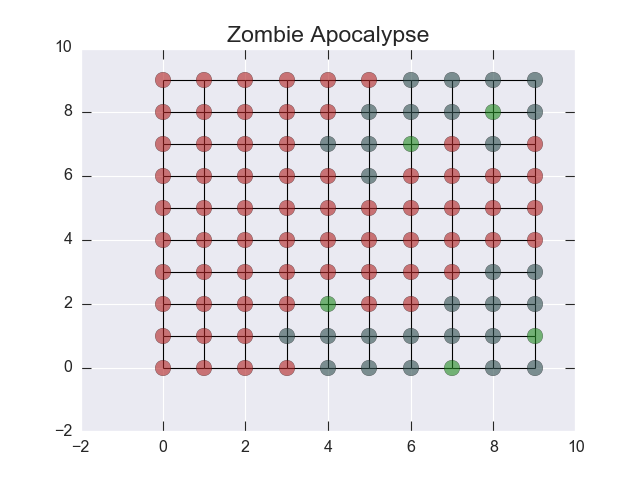

random selection done
same cluster selection done
Steps until encounter for randomly selected nodes: 67.1
Steps until encounter for nodes from same cluster: 59.1


In [3]:
import networkx as nx
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib nbagg
size=100

#make sure we always use the same graph to make results comparable
graph_found = False
for file in os.listdir(os.getcwd()):
    if file == "power_law_cluster_graph.gpickle":
        graph_found = True
if not graph_found:
    #m = 2 and p = 0.6 seem to fit our needs
    G = nx.powerlaw_cluster_graph(size,2,0.6)
    nx.write_gpickle(G,"power_law_cluster_graph.gpickle")
else:
    G = nx.read_gpickle("power_law_cluster_graph.gpickle")

pos = nx.spring_layout(G,k=0.1)

#we try to find clusters by detecting nodes with an unusually high degree
#we define a cluster as each of these special nodes and their neighbors
#this already is an automatic way to identify clusters
degrees = list(nx.degree(G).values())
cluster_threshold = 2.5*np.asarray(degrees).mean()
clusters = []
for i,d in enumerate(degrees):
    if d > cluster_threshold:
        c = [i]
        c.extend(G.neighbors(i))
        clusters.append(c)

#we create a list of possible colors so we can assign a color to each cluster
#could also do this with a colormap to avoid an index error in the color_list
color_list = ['red','blue','green','yellow','purple','SkyBlue','maroon',\
              'GoldenRod','salmon']

#we create a lookup table for the color of every node
#we also want to make nodes that do not belong to any cluster appear in gray
#and smaller than the nodes in the clusters
colors = ['gray']*len(G.nodes())
sizes = [100]*len(G.nodes())

for i,c in enumerate(clusters):
    color = color_list[i]
    for n in c:
        colors[n] = color
        sizes[n] = 300
    
#finally we draw the graph using the colors and sizes determined above 
#this way to color nodes still has the drawback that if a node belongs to
#more than one cluster, it will always be drawn with the color of the latest
#cluster to check. Maybe implement combination-colors for these nodes.
nx.draw_networkx(G, pos=pos, node_size=sizes, node_color=colors, \
                 font_size=8, alpha = 0.6)
plt.savefig("cluster_graph.pdf")

#define a function that performs a random walk from one node to one of
#its neighbors
def walk(node):
    neighbors = nx.neighbors(G,node)
    choose = np.random.random_integers(0,len(neighbors)-1)
    return neighbors[choose]

random = []
same = []

#randomly select two nodes in the graph 10000 times and record the time
#until the two walkers meet
for i in range(10000):
    n1 = np.random.random_integers(0,size-1)
    n2 = np.random.random_integers(0,size-1)
    while n2 == n1:
        n2 = np.random.random_integers(0,size-1)#
    j = 0
    while n1 != n2:
        n1 = walk(n1)
        n2 = walk(n2)
        j += 1
    random.append(j)
    
print("random selection done")
   
#randomly select a cluster and then randomly select two nodes both belonging to
#the same cluser. Record the time until the two walkers meet.
for i in range(10000):
    cluster = clusters[np.random.random_integers(0,len(clusters)-1)]
    n1 = cluster[np.random.random_integers(0,len(cluster)-1)]
    n2 = cluster[np.random.random_integers(0,len(cluster)-1)]
    while n2 == n1:
        n2 = cluster[np.random.random_integers(0,len(cluster)-1)]
    j = 0
    while n1 != n2:
        n1 = walk(n1)
        n2 = walk(n2)
        j += 1
    same.append(j)
    
print("same cluster selection done")

#trial and error shows that for around 10000 iterations one gets relatively
#consistent averages of steps needed until the two walkers meet
random_time = np.asarray(random).mean()
same_time = np.asarray(same).mean()
print("Steps until encounter for randomly selected nodes: %1.1f"%(random_time))
print("Steps until encounter for nodes from same cluster: %1.1f"%(same_time))


# 2. Zombie Apocalypse

HINT: for the following you can either use an object oriented or functional
approach to make your life easier. It is also possible to handle zombiism via
node attributes in the graph although it might be a bit less intuitive.

a) Create a two-dimensional grid graph with around 100 × 100 nodes. Every
node holds a healthy human which has regular contact with its neighbors.

b) Start the apocalypse by infecting nodes either i. at one, two or n random locations
ii. at the border of the grid
c) At each step the infected humans (zombies) have a probability p of biting
each of their neighbors and turning them into zombies. Implement a
method to visualize healthy and infected humans in the graph and to
track the spreading of the infection.
d) Investigate how long it takes for the whole population to get infected
and how this depends on the infection probability p and the number and
position of initial zombies. Visualize how the virus spreads throuout the
population.

e) At each step, one random zombie is intelligent enough to bord an airplane.
This Zombie tries to find and infect a human at a location no less than
5 edges away from its initial position. How does aviation influence the
apocalypse?

f) Someone has developed a cure for zombiism. Once infected it takes a
zombie m turns to become human again. Can you find a balance between
m and p such that the cure keeps the virus in check and at every time
there are only a constant number of persons infected?
What if the zombies don’t cure themselves but there is a third species
of humans - the doctors - moving through the grid at random curing all
zombies around them? How many doctors do we need to prevent the
apocalypse?
g) What do you think would be the most efficient way to prevent the spread-
ing of the infection throughout the whole population?

In [ ]:
from numpy.random import random_integers

size = 10                       #size of the grid
m = 1                           #number of steps until the infection wars off
p = 0.4                         #infection probability
doctors_present = True          #are there doctors?
d = 5                           #number of doctors
initial_condition = 'corner'    #initial zombie starting point/number

def create_grid(size):
    #hand-made two-dimensional grid graph
    G = nx.empty_graph(size*size)
    for i in range(size*size):
        #connect left
        if i%size != 0:
            G.add_edge(i,i-1)
        #connect right
        if i%size != size-1:
            G.add_edge(i,i+1)
        #connect up
        if i - size > 0:
            G.add_edge(i,i - size)
        #connect down
        if i + size < size*size:
            G.add_edge(i,i + size)
            
    #add coordinates for plotting
    for k in range(size):
        for l in range(size):
            G.node[k*size+l]['x'] = l
            G.node[k*size+l]['y'] = k
            
    pos = {}
    for k in G.node.keys():
        pos[k] = (G.node[k]['x'],G.node[k]['y'])
            
    return (G,pos)


#helper functions for setting zombies, doctors and humans
def set_zombie(G,index):
    G.node[index]['creature'] = 'zombie'
    G.node[index]['time_to_cure'] = m
        
def set_doctor(G,index):
    G.node[index]['creature'] = 'doctor'
    G.node[index]['time_to_cure'] = 0
    
def set_human(G,index):
    G.node[index]['creature'] = 'human'
    G.node[index]['time_to_cure'] = 0

#helper function to swap the attributes of two nodes    
def swap_places(G,index1,index2):
    temp_creature = G.node[index2]['creature']
    temp_time_to_cure = G.node[index2]['time_to_cure']
    G.node[index2]['creature'] = G.node[index1]['creature']
    G.node[index1]['creature'] = temp_creature
    G.node[index2]['time_to_cure'] = G.node[index1]['time_to_cure']
    G.node[index1]['time_to_cure'] = temp_time_to_cure
 
#helper function to check if a zombie is cured   
def check_cured(G):
    for n in G.nodes():
        if G.node[n]['time_to_cure'] == 0:
            G.node[n]['creature'] = 'human'

#initiate the grid
def init(G,initial_condition):
    attr = {n:'human' for n in G.nodes()}        
    nx.set_node_attributes(G,'creature',attr)
    attr = {n:0 for n in G.nodes()}        
    nx.set_node_attributes(G,'time_to_cure',attr)
    
    if initial_condition == 'edge':
        index = int(size/2)
        set_zombie(G,index)
    elif initial_condition == 'corner':
        index = 0
        set_zombie(G,index)                    
    elif initial_condition == 1:
        index = random_integers(0,size*size-1)
        set_zombie(G,index)
    elif initial_condition == 2:
        index1 = random_integers(0,size*size-1)
        index2 = random_integers(0,size*size-1)
        while index1 == index2:
            index2 = random_integers(0,size*size-1)
        set_zombie(G,index1)
        set_zombie(G,index2)
    else:
        indices = [random_integers(0,size*size-1) for j in range(initial_condition)]
        for index in indices:        
            set_zombie(G,index)
    
    if doctors_present:
        i = 0
        while i < d:
            index = np.random.random_integers(0,size*size - 1)
            if G.node[index]['creature'] == 'human':
                set_doctor(G,index)
                i += 1   

#perform one standard infectuous step
def infection_step(G):
    infected = [n for n in G.nodes() if G.node[n]['creature'] == 'zombie']
    for i in infected: 
        for neighbor in G.neighbors(i):
            if np.random.rand() < p:
                set_zombie(G,neighbor)
                
#perform one infectuous step with flying zombies
def infection_step_flying(G):
    infected = [n for n in G.nodes() if G.node[n]['creature'] == 'zombie']
    #select a random zombie
    random_zombie = infected[np.random.random_integers(0,len(infected) - 1)]
    #select a random tile at least size/2 edges away from the zombie 
    path_length = 0
    while path_length < size/2:
        target = np.random.random_integers(0,size*size - 1)
        path_length = len(nx.shortest_path(G,random_zombie,target))
    if np.random.rand() < p:
        set_zombie(G,target)
    
    for i in infected: 
        for neighbor in G.neighbors(i):
            if np.random.rand() < p:
                set_zombie(G,neighbor)

#perform one infectuous step with zombies self-curing after m steps                
def infection_step_self_curing(G):
    #first check if there are some cured zombies becoming human again
    check_cured(G)
    infected = [n for n in G.nodes() if G.node[n]['creature'] == 'zombie']
    for i in infected: 
        for neighbor in G.neighbors(i):
            if np.random.rand() < p and G.node[neighbor]['creature'] != 'zombie':
                set_zombie(G,neighbor)
    
    for i in infected:
        G.node[i]['time_to_cure'] -= 1

#perform one infectuous step with doctors moving randomly through the grid and
#curing zombies around them
def infection_step_doctors(G):
    #infect the healthy
    infected = [n for n in G.nodes() if G.node[n]['creature'] == 'zombie']
    for i in infected: 
        for neighbor in G.neighbors(i):
            if np.random.rand() < p and G.node[neighbor]['creature'] == 'human':
                set_zombie(G,neighbor)    
    
    #cure the infected
    doctors = [n for n in G.nodes() if G.node[n]['creature'] == 'doctor']
    for doctor in doctors:
        for neighbor in G.neighbors(doctor):
            if G.node[neighbor]['creature'] == 'zombie':
                set_human(G,neighbor)
                
    #move the doctors
    for doctor in doctors:
        neighbors = G.neighbors(doctor)
        target = np.random.random_integers(0,len(neighbors) - 1)
        swap_places(G,doctor,neighbors[target])
    
#function to plot the graph and save the image with a distinct filename
def plot(G,pos,t):
    plt.clf()
    plt.title('Zombie Apocalypse')
    nx.draw_networkx_edges(G,pos=pos)
    infected = [n for n in G.nodes() if G.node[n]['creature'] == 'zombie']
    healthy = [n for n in G.nodes() if G.node[n]['creature'] == 'human']
    doctors = [n for n in G.nodes() if G.node[n]['creature'] == 'doctor']
    
    nx.draw_networkx_nodes(G,pos=pos,nodelist=healthy,\
            node_color='DarkSlateGray',alpha=0.6,node_size=200)
    nx.draw_networkx_nodes(G,pos=pos,nodelist=infected,\
            node_color='FireBrick',alpha=0.6,node_size=200)
    nx.draw_networkx_nodes(G,pos=pos,nodelist=doctors,\
            node_color='ForestGreen',alpha=0.6,node_size=200)
            
    plt.savefig("apocalypse_%d.png"%t)
    

#create the graph
G,pos = create_grid(size)

#initialize the zombies/doctors on the graph
init(G,initial_condition)

#initialize break-conditions
humanity_alive = 'human' in nx.get_node_attributes(G,'creature').values()
zombiism_cured = 'zombie' not in nx.get_node_attributes(G,'creature').values()

#initialize time-step and time-step-hardcap
t = 0
hardcap = 100

#"main" loop
while humanity_alive and not zombiism_cured and hardcap > 0:
    print("infection step %d"%t)
    
    #create a plot every 3 timesteps
    if t%3 == 0:
        plot(G,pos,t)
        
    #perform an infection step (use the step-function of choice here)
    infection_step_doctors(G)
    
    #increase timestep and update break conditions
    t += 1
    humanity_alive = 'human' in nx.get_node_attributes(G,'creature').values()
    zombiism_cured = 'zombie' not in nx.get_node_attributes(G,'creature').values()
    hardcap -= 1

#print final result
if humanity_alive == False:  
    print("it took %d timesteps to destroy humanity"%t)
elif zombiism_cured == True:
    print("it took %d timesteps to cure zombiism"%t)
else:
    print("hardcap for time-steps reached, aborting...")

infection step 0
infection step 1
infection step 2
infection step 3
infection step 4
infection step 5
infection step 6
infection step 7
infection step 8
infection step 9
infection step 10
infection step 11
infection step 12
infection step 13
infection step 14
infection step 15
infection step 16
infection step 17
infection step 18
infection step 19
infection step 20
infection step 21
infection step 22
infection step 23
infection step 24
infection step 25
infection step 26
infection step 27
infection step 28
infection step 29
infection step 30
infection step 31
infection step 32
infection step 33
infection step 34
infection step 35
infection step 36
infection step 37
infection step 38
infection step 39
infection step 40
infection step 41
infection step 42
infection step 43
infection step 44
infection step 45
infection step 46
infection step 47
infection step 48
infection step 49

# 3. The Slime Mold

A slime mold is an unicellular organism. It starts out from a single spot (we call
it the “core”) and grows out tendrils to investigate its neighborhood. Whenever
a tendril finds a food source, it attaches to the source and funnels nutrients to
the core until the source is depleted. Our goal is to simulate the growing of
a slime mold and program our mold in a way that it survives for the longest
possible time.

a) Create a network starting from one node that grows tendrils randomly
in all directions creating a web with a maximal radius r = 10. Grow the
network sequentially, at each timestep each edge can only grow a maximum
distance of r/10 in length. Visualize the network.

b) Create the surroundings of the mold by putting food sources randomly in
the region between r/2 and r away from the core. Assign a random number
of food units u ∈ [1, 10] to each food source. Implement a functionality
that keeps track of the value of u in each food source. Control the rate k
of new food units per timestep so that k ≈ 3.

c) Implement a function that makes a tendril recognize the source when it
is closer to it than r/10. Each tendril can transport a maximum of c = 2
food units to the core each timestep.

d) The core needs one food unit each timestep. To support its tendrils, the
core needs an additional unit of food equal to the total length of the
network divided by r (round to the nearest integer).

e) Implement a functionality that lets edges decay (vanish) if they have
reached the perimeter and not found any new food or if their food source
is depleted.

f) Let the core start with an initial supply of u i = 10. The mold dies if it
has no more food left at the end of a timestep. Try to answer some of the
following questions:

i. What is the likelihood of your mold surviving the first 10 timesteps?
The first 100?
ii. Does it get easier or more difficult for the mold to survive with in-
creasing time?
iii. What influence do the parameters r, u i , k and c have on the survival
of the mold?
iv. What are weaknesses of the model? Can you think of improvements
to the model to make it more realistic?